In [22]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'
train = pd.read_csv(PATH + 'application_train.csv')
print('train')
test = pd.read_csv(PATH + 'application_test.csv')
print('test')
# bureau = pd.read_csv(PATH + 'bureau.csv')
# print('bureau')
# previous_application = pd.read_csv(PATH + 'previous_application.csv')
# print('previous')
# bureau_balance = pd.read_csv(PATH + 'bureau_balance.csv')
# print('bureau_balance')
# installments_payments = pd.read_csv(PATH + 'installments_payments.csv')
# print('installments_payments done')
# credit_card_balance = pd.read_csv(PATH + 'credit_card_balance.csv')
# # print('credit_card_balance')
POS_CASH_balance = pd.read_csv(PATH + 'POS_CASH_balance.csv')
print('POS_CASH_balance')
# credit_card_balance = pd.read_csv(PATH + 'credit_card_balance.csv')
# print('credit_card_balance')
# previous_application = pd.read_csv(PATH + 'previous_application.csv')
# print('previous_application')

train
test
POS_CASH_balance


In [23]:
import pandas as pd
import os
import gc
import numpy as np

def ratio_name(numerator, denominator): return numerator + '_' + denominator + '_ratio'

def ratio(df, numerator, denominator):
    return df[numerator] / df[denominator]

def substraction_name(col1, col2): return col1 + '_minus_' + col2

def substraction(df, col1, col2):
    return df[col1] - df[col2]


# Substraction and ratio , and score for dpd

In [24]:
POS_CASH_balance[substraction_name('CNT_INSTALMENT','CNT_INSTALMENT_FUTURE')] = \
substraction(POS_CASH_balance, 'CNT_INSTALMENT','CNT_INSTALMENT_FUTURE')
POS_CASH_balance[ratio_name('CNT_INSTALMENT_FUTURE','CNT_INSTALMENT')] = ratio(POS_CASH_balance,'CNT_INSTALMENT_FUTURE','CNT_INSTALMENT')

numerical_cols = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE','SK_DPD','SK_DPD_DEF','CNT_INSTALMENT_minus_CNT_INSTALMENT_FUTURE','CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_ratio']
categorical_cols = ['NAME_CONTRACT_STATUS']

In [63]:
pos = POS_CASH_balance.copy()
pos['score_DPD'] = 0
pos = pos.sort_values('MONTHS_BALANCE')
pos['score_DPD'] = (pos['SK_DPD']**3 + 5* pos['SK_DPD_DEF']**3 + 1) * (1/(1 + abs(pos['MONTHS_BALANCE']) ))

In [64]:
l= pos['score_DPD'] .head(50)
print(l.max(),
l.min(),
l.std(),
l.mean())

161.09278350515464 0.010309278350515464 23.740229070455978 4.2449484536082505


In [6]:
POS_CASH_balance['SK_DPD'].dtypes

dtype('int64')

In [33]:
def numerical_agg(df, gp_col, agg_col, df_name, extrafunc_list = None):
    
    agg_list = ['max', 'min', 'std','mean']
    '''
    Possible extrafunc_list: ['sum','median','two_minus_one_third','positive_count', 'negative_count','standard_error', 'trimmed_mean_10_pct', 'trimmed_mean_25_pct','normed_std', 'max_minus_min','one_third','two_third']
    '''
    if extrafunc_list:
        if 'one_third' in extrafunc_list:
            def one_third(series):
                return series.quantile(1/3)
            
        if 'two_third' in extrafunc_list:
            def two_third(series):
                return series.quantile(2/3)
            
        if 'max_minus_min' in extrafunc_list:
            def max_minus_min(series):
                return (series.max() - series.min())
        
        if 'two_minus_one_third' in extrafunc_list:
#             print('two_minus_one')
#             print('get two minus one')
            def two_minus_one_third(series):
                return(series.quantile(0.66666) - series.quantile(0.33333))
       
        if 'positive_count' in extrafunc_list:
#             print('get positive count')
            def positive_count(series):
                return pd.Series(series > 0).sum()

        if 'negative_count' in extrafunc_list:
#             print('get negative count')
            def negative_count(series):
                return pd.Series(series < 0).sum()

        if 'standard_error' in extrafunc_list:
#             print('get std-error')
            def standard_error(series):
                return series.std()/np.sqrt(len(series))

        if 'normed_std' in extrafunc_list:
#             print('get normed_std')
            def normed_std(series):
                return series.std()/series.mean()

        if 'trimmed_mean_10_pct' in extrafunc_list:
#             print('get_trimmed 10 pct')
            def trimmed_mean_10_pct(series):
                return stats.trim_mean(series.dropna(), 0.1)

        if 'trimmed_mean_25_pct' in extrafunc_list:
#             print('get_trimmed 25 pct')
            def trimmed_mean_25_pct(series):
                return stats.trim_mean(series.dropna(), 0.25)
        
        list_tocall = []
        for i in extrafunc_list:
            if i not in set(['sum', 'median']):
                list_tocall.append(eval(i))
            
    if extrafunc_list != None:   
        agg_list.extend(list_tocall)
    
    _df = df.groupby(gp_col).agg({agg_col:agg_list})
    columns = []
    for pre in _df.columns.levels[0]:
        for middle in _df.columns.levels[1]:
            columns.append('%s_%s_%s' %(df_name,pre,middle))
    _df.columns = columns
    
    return _df.reset_index()

#  Pos_cash_Numerical

In [35]:
gp_col = 'SK_ID_CURR'
numerical_cols= ['CNT_INSTALMENT','CNT_INSTALMENT_FUTURE','SK_DPD','SK_DPD_DEF',\
                 'CNT_INSTALMENT_minus_CNT_INSTALMENT_FUTURE','CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_ratio','score_DPD']

'''
    Possible extrafunc_list: ['sum','median','two_minus_one_third','positive_count', 'negative_count','standard_error', 'trimmed_mean_10_pct', 'trimmed_mean_25_pct','normed_std', 'max_minus_min','one_third','two_third']
    '''
extrafunc_list = [None,None,['positive_count'],['positive_count'],None,None]

for i in range(6):
    print(extrafunc_list[i])
    train = train.merge(numerical_agg(POS_CASH_balance, gp_col, numerical_cols[i], 'POS_CASH_balance', extrafunc_list = extrafunc_list[i]), on = 'SK_ID_CURR', how='left')

None
None
['positive_count']
['positive_count']
None
None


# Count for DPD and Default

In [36]:
def split_categorical_feature(df, group_col, calc_col):
    tmp_df = pd.concat([df[group_col], pd.get_dummies(df[calc_col], prefix=calc_col)], axis=1).groupby(by=group_col).sum().reset_index()
    dtype = {x: _set_type(tmp_df[x], 'uint') for x in tmp_df.columns if x != group_col}
    for x in tmp_df:
        if x in df.columns:
            dtype[x] = df[x].dtype
    return tmp_df.astype(dtype)

In [38]:
categorical_cols = ['NAME_CONTRACT_STATUS']

def _set_type(series, dtype):
    _max, _min = max(series), min(series)
    if dtype == 'uint':
        if _max <= 255: return np.uint8
        elif _max <= 65535: return np.uint16
        elif _max <= 4294967295: return np.uint32
        else: return np.uint64
    elif dtype == 'int':
        if _min >= -128 and _max <= 127: return np.int8
        elif _min >=-32768 and _max <= 32767: return np.int16
        elif _min >= -2147483648 and _max <= 2147483647: return np.int32
        else: return np.int64
    elif dtype == 'float':
        if max(abs(_min), _max) <= 3.4028235e+38: return np.float32
        else: return np.float64
        
for x in categorical_cols:
    print(x)
    train = train.merge(split_categorical_feature(POS_CASH_balance, 'SK_ID_CURR', x), on='SK_ID_CURR', how='left')
    gc.collect()

NAME_CONTRACT_STATUS


In [52]:
len(train.columns.values)

157

In [40]:
train[['POS_CASH_balance_CNT_INSTALMENT_max',
       'POS_CASH_balance_CNT_INSTALMENT_min',
       'POS_CASH_balance_CNT_INSTALMENT_std',
       'POS_CASH_balance_CNT_INSTALMENT_mean',
       'POS_CASH_balance_CNT_INSTALMENT_FUTURE_max',
       'POS_CASH_balance_CNT_INSTALMENT_FUTURE_min',
       'POS_CASH_balance_CNT_INSTALMENT_FUTURE_std',
       'POS_CASH_balance_CNT_INSTALMENT_FUTURE_mean',
       'POS_CASH_balance_SK_DPD_max', 'POS_CASH_balance_SK_DPD_min',
       'POS_CASH_balance_SK_DPD_std', 'POS_CASH_balance_SK_DPD_mean',
       'POS_CASH_balance_SK_DPD_positive_count',
       'POS_CASH_balance_SK_DPD_DEF_max',
       'POS_CASH_balance_SK_DPD_DEF_min',
       'POS_CASH_balance_SK_DPD_DEF_std',
       'POS_CASH_balance_SK_DPD_DEF_mean',
       'POS_CASH_balance_SK_DPD_DEF_positive_count',
       'POS_CASH_balance_CNT_INSTALMENT_minus_CNT_INSTALMENT_FUTURE_max',
       'POS_CASH_balance_CNT_INSTALMENT_minus_CNT_INSTALMENT_FUTURE_min',
       'POS_CASH_balance_CNT_INSTALMENT_minus_CNT_INSTALMENT_FUTURE_std',
       'POS_CASH_balance_CNT_INSTALMENT_minus_CNT_INSTALMENT_FUTURE_mean',
       'POS_CASH_balance_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_ratio_max',
       'POS_CASH_balance_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_ratio_min',
       'POS_CASH_balance_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_ratio_std',
       'POS_CASH_balance_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_ratio_mean',
       'NAME_CONTRACT_STATUS_Active',
       'NAME_CONTRACT_STATUS_Amortized debt',
       'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled',
       'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand',
       'NAME_CONTRACT_STATUS_Returned to the store',
       'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_XNA']].head(50)

,POS_CASH_balance_CNT_INSTALMENT_max,POS_CASH_balance_CNT_INSTALMENT_min,POS_CASH_balance_CNT_INSTALMENT_std,POS_CASH_balance_CNT_INSTALMENT_mean,POS_CASH_balance_CNT_INSTALMENT_FUTURE_max,POS_CASH_balance_CNT_INSTALMENT_FUTURE_min,POS_CASH_balance_CNT_INSTALMENT_FUTURE_std,POS_CASH_balance_CNT_INSTALMENT_FUTURE_mean,POS_CASH_balance_SK_DPD_max,POS_CASH_balance_SK_DPD_min,...,POS_CASH_balance_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_ratio_mean,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Amortized debt,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Canceled,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_XNA
0,24.0,24.0,0.000000,24.000000,24.0,6.0,5.627314,15.000000,0.0,0.0,...,0.625000,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.0,6.0,2.806597,10.107143,12.0,0.0,3.842811,5.785714,0.0,0.0,...,0.544643,26.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,4.0,3.0,0.500000,3.750000,4.0,0.0,1.707825,2.250000,0.0,0.0,...,0.562500,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,48.0,1.0,9.279292,12.000000,48.0,0.0,10.163272,8.650000,0.0,0.0,...,0.570833,18.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
4,24.0,10.0,4.884302,15.333333,24.0,0.0,6.312307,8.969697,0.0,0.0,...,0.557561,62.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0
5,30.0,6.0,6.188820,11.518072,30.0,0.0,7.880219,4.108434,1294.0,0.0,...,0.262249,78.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0
6,12.0,5.0,2.705080,7.875000,12.0,0.0,3.268264,3.781250,0.0,0.0,...,0.461979,57.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
7,10.0,10.0,0.000000,10.000000,10.0,0.0,3.316625,5.000000,0.0,0.0,...,0.500000,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,30.0,11.0,8.889248,19.186667,30.0,0.0,9.083695,7.000000,952.0,0.0,...,0.285333,73.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
9,24.0,9.0,5.821375,19.021739,23.0,0.0,6.366276,10.217391,0.0,0.0,...,0.537138,43.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [41]:
POS_CASH_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF', 'CNT_INSTALMENT_minus_CNT_INSTALMENT_FUTURE',
       'CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_ratio'], dtype=object)

In [42]:
x = POS_CASH_balance[POS_CASH_balance['SK_DPD']<=POS_CASH_balance['SK_DPD_DEF']]

In [43]:
x.shape

(9817478, 10)

In [44]:
POS_CASH_balance.shape

(10001358, 10)

In [53]:
POS_CASH_balance['MONTHS_BALANCE'].min()

-96

[]

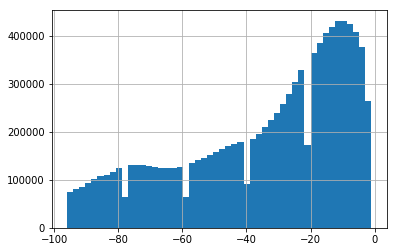

In [58]:
p = pos['MONTHS_BALANCE'].hist(bins = 50)
p.plot()